For this project I will be using `Annotation Averaged Per Song` because it simplies the task and provides a more consistent emotional profile for entire song.

Steps Involved:
1. EDA
2. PCA
3. Clustering
4. Classification

In [6]:
# step 0: Data Loading
import pandas as pd


arousal_path = './data/annotations/arousal.csv'
valence_path = './data/annotations/valence.csv'

# Load the CSV files into dataframes
arousal_df = pd.read_csv(arousal_path)
valence_df = pd.read_csv(valence_path)

# Display first few rows of both dataframes to understand the structure
arousal_df.head(), valence_df.head()


(   song_id  sample_15000ms  sample_15500ms  sample_16000ms  sample_16500ms  \
 0        2       -0.109386       -0.114942       -0.116413       -0.118613   
 1        3       -0.110846       -0.123973       -0.131103       -0.135956   
 2        4        0.222327        0.179446        0.178388        0.184056   
 3        5       -0.255613       -0.251579       -0.251958       -0.251124   
 4        7        0.464234        0.460789        0.460991        0.461046   
 
    sample_17000ms  sample_17500ms  sample_18000ms  sample_18500ms  \
 0       -0.126457       -0.133199       -0.136855       -0.144713   
 1       -0.140775       -0.144664       -0.163118       -0.165218   
 2        0.176042        0.178720        0.176345        0.175793   
 3       -0.250763       -0.251957       -0.251957       -0.251957   
 4        0.457240        0.465702        0.471809        0.469918   
 
    sample_19000ms  ...  sample_622000ms  sample_622500ms  sample_623000ms  \
 0       -0.138985  ... 

Based on the structure of the arousal and valence datasets, the data contains time-series information of various time stamps like sample_15000ms, sample_15500ms, etc. for each song. The first column is the song_id, followed by sampled values of arousal and valence at different time intervals.

# Step 1: `EDA`
1. To get insights into the data, such as distribution, missing values, correlations, and overall trends in the valence and arousal ratings over time. 
2. This helps identify potential issues and guide decisions for feature selection and model building.

In [7]:
# EDA: Checking for missing values
arousal_missing = arousal_df.isnull().sum().sum()
valence_missing = valence_df.isnull().sum().sum()

# EDA: Summary statistics for valence and arousal (initial time series)
arousal_summary = arousal_df.describe()
valence_summary = valence_df.describe()

# Display the summary and missing values count
arousal_missing, valence_missing, arousal_summary, valence_summary


(np.int64(2075649),
 np.int64(2073848),
            song_id  sample_15000ms  sample_15500ms  sample_16000ms  \
 count  1802.000000     1802.000000     1802.000000     1802.000000   
 mean   1093.215871        0.123961        0.124999        0.125694   
 std     599.658004        0.266756        0.267682        0.268578   
 min       2.000000       -0.654305       -0.654348       -0.655628   
 25%     569.500000       -0.071864       -0.070000       -0.072250   
 50%    1157.500000        0.139000        0.140830        0.144438   
 75%    1607.750000        0.341000        0.341581        0.343351   
 max    2058.000000        0.678000        0.687000        0.688000   
 
        sample_16500ms  sample_17000ms  sample_17500ms  sample_18000ms  \
 count     1802.000000     1802.000000     1802.000000     1802.000000   
 mean         0.126370        0.126515        0.126578        0.126825   
 std          0.269261        0.269770        0.270248        0.270959   
 min         -0.663082 

# Step 2: `PCA`
1. PCA is used to reduce dimensionality while preserving as much variance in the data as possible. 
2. If the data has a lot of features (in this case, we have many time points for each song), PCA can help reduce it to a smaller set of features.

In [8]:
# Handle missing values by forward filling and backward filling, keeping as much data as possible
arousal_df_filled = arousal_df.fillna(method='ffill').fillna(method='bfill')
valence_df_filled = valence_df.fillna(method='ffill').fillna(method='bfill')

# Check if there are still any missing values after filling
arousal_missing_after = arousal_df_filled.isnull().sum().sum()
valence_missing_after = valence_df_filled.isnull().sum().sum()

arousal_missing_after, valence_missing_after


/var/folders/tr/m7nnfyd94_jfxmdwqvwq7hg40000gn/T/ipykernel_67474/2480152640.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arousal_df_filled = arousal_df.fillna(method='ffill').fillna(method='bfill')
/var/folders/tr/m7nnfyd94_jfxmdwqvwq7hg40000gn/T/ipykernel_67474/2480152640.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  valence_df_filled = valence_df.fillna(method='ffill').fillna(method='bfill')


(np.int64(0), np.int64(0))

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# We will scale the data before applying PCA
scaler = StandardScaler()

# Remove the 'song_id' column for PCA and scale the rest of the data
arousal_data_scaled = scaler.fit_transform(arousal_df_filled.drop(columns=['song_id']))
valence_data_scaled = scaler.fit_transform(valence_df_filled.drop(columns=['song_id']))

# Perform PCA to reduce the dimensions (let's start with 2 components)
pca_arousal = PCA(n_components=2)
pca_valence = PCA(n_components=2)

arousal_pca_result = pca_arousal.fit_transform(arousal_data_scaled)
valence_pca_result = pca_valence.fit_transform(valence_data_scaled)

# Display the explained variance ratio for both PCA models
pca_arousal.explained_variance_ratio_, pca_valence.explained_variance_ratio_


(array([0.6012353 , 0.13271734]), array([0.60310733, 0.21496849]))

# Step 3 `Clustering`
1. It help discover natural groupings of songs based on their emotional profiles (valence and arousal).
2. It is useful for exploring how songs might naturally fall into categories of emotions

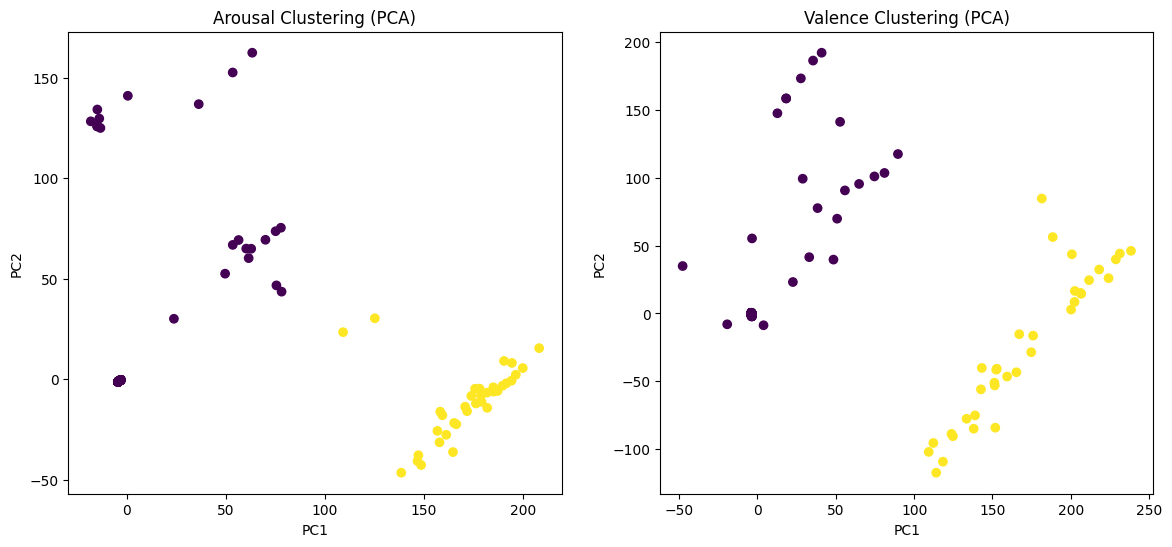

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-Means clustering with 2 clusters (since we're interested in binary classification)
kmeans_arousal = KMeans(n_clusters=2, random_state=42)
kmeans_valence = KMeans(n_clusters=2, random_state=42)

# Fit the models on the PCA results
arousal_clusters = kmeans_arousal.fit_predict(arousal_pca_result)
valence_clusters = kmeans_valence.fit_predict(valence_pca_result)

# Plotting the PCA components and the clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Arousal Clusters
ax1.scatter(arousal_pca_result[:, 0], arousal_pca_result[:, 1], c=arousal_clusters, cmap='viridis')
ax1.set_title('Arousal Clustering (PCA)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# Valence Clusters
ax2.scatter(valence_pca_result[:, 0], valence_pca_result[:, 1], c=valence_clusters, cmap='viridis')
ax2.set_title('Valence Clustering (PCA)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

plt.show()


# Step 4 `Classification`
1. Classification task aims to predict binary emotional states based on the valence and arousal values.
2. We will use models like decision trees or random forests to predict emotion labels based on the data.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare the data for classification
# Combine arousal and valence PCA results and cluster labels
X = pd.DataFrame({
    'arousal_PC1': arousal_pca_result[:, 0],
    'arousal_PC2': arousal_pca_result[:, 1],
    'valence_PC1': valence_pca_result[:, 0],
    'valence_PC2': valence_pca_result[:, 1]
})

# Use the arousal clusters for binary classification as target labels (could use valence as well)
y = arousal_clusters

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep


(1.0,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       351\n           1       1.00      1.00      1.00        10\n\n    accuracy                           1.00       361\n   macro avg       1.00      1.00      1.00       361\nweighted avg       1.00      1.00      1.00       361\n')

In [12]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation (5-fold) to evaluate the robustness of the model
cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

# Calculate mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

cv_mean, cv_std, cv_scores


(np.float64(0.9949999999999999),
 np.float64(0.010000000000000009),
 array([1.   , 1.   , 1.   , 1.   , 0.975]))